In [4]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from pyens.models import Flywheel, OCV, EcmCell
from pyens.utilities import ivp
from pyens.simulations import Data, Current, Learner,Simulator
import os
import matplotlib.pyplot as plt

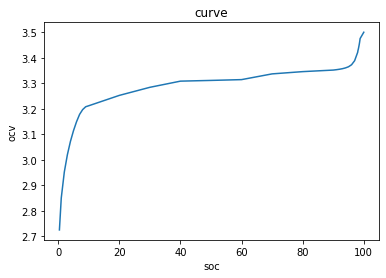

In [5]:

ocv = [
    2.725578,
    2.850545,
    2.952456,
    3.020007,
    3.072155,
    3.114243,
    3.149442,
    3.178211,
    3.196915,
    3.208162,
    3.21203,
    3.252616,
    3.284272,
    3.308415,
    3.311269,
    3.314391,
    3.336869,
    3.345692,
    3.351787,
    3.353211,
    3.354968,
    3.357175,
    3.360247,
    3.364758,
    3.372647,
    3.388452,
    3.421374,
    3.428617,
    3.433137,
    3.438826,
    3.444884,
    3.4514,
    3.458486,
    3.466429,
    3.475249,
    3.5,
]
soc = [
    0.397351,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    98.1,
    98.2,
    98.3,
    98.4,
    98.5,
    98.6,
    98.7,
    98.8,
    100.0,
]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

the training dataset has a gap , during which the cell is relaxing,

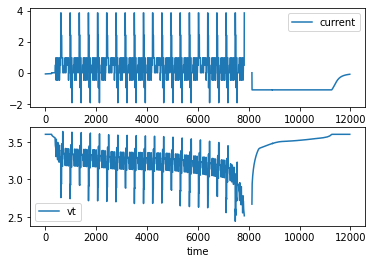

In [15]:

TESTDATA_FILEPATH = os.path.join(os.path.dirname(os.getcwd()),
'tests/cycling/main-data-as-seriestocolumns-2022-08-05 15_37_19.xlsx')

# data come from https://web.calce.umd.edu/batteries/data.htm

schema = {
    "Time": "time",
    "Cell_LFP_CALCE_A1_007.max_current": "current",
    "Cell_LFP_CALCE_A1_007.max_v_tr": "vt",
    "rsv_i_dir": False,
}
d1 = Data(name="d1", df=None)
d1.fetch_file(TESTDATA_FILEPATH, schema=schema)
d1.to_abs_time()
d1.disp()

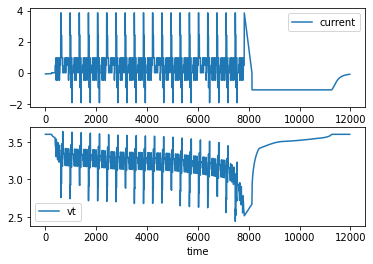

In [16]:
d1.df.interpolate(method='linear',inplace=True)
d1.df.dropna(inplace=True)
d1.disp()

In [17]:
d1.df.reset_index(inplace=True)

In [35]:
param_sim = {
    "R0": 1,
    "R1": 1,
    "C1": 1500,
    "R2": 2,
    "C2": 30000,
    "CAP": 1.1,
    "ce": 0.99,
    "v_limits": [1.5, 4.5],
    "SOC_RANGE": [0.0, 100.0],
}
m_sim = EcmCell(name="cell_model_sim", parameters=param_sim, curve=c1)
l2 = Learner(name="l2")
l2.attach(d1).attach(m_sim)
x0_sim = np.array([0.05, 0.05, 100])

config = {
    "solver_type": "adaptive",
    "solution_name": "sol1",
    "max_step":np.inf,
    'maxiter':20,
    'method':'Powell'}

method = "global"
bounds=(
    (1e-2, 5),
    (.1, 10),
    (.1, 5000),
    (.1, 50),
    (.1, 50000),
    (0.9, 1.2),
)


In [36]:
res = l2.fit_parameters(("cell_model_sim", "d1"), config, x0_sim, method,bounds)

/workspaces/pyens/.venv/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:533: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


differential_evolution step 1: f(x)= 0.364657
differential_evolution step 2: f(x)= 0.230135
differential_evolution step 3: f(x)= 0.139885
differential_evolution step 4: f(x)= 0.139885
differential_evolution step 5: f(x)= 0.139885
differential_evolution step 6: f(x)= 0.139885
differential_evolution step 7: f(x)= 0.134842
differential_evolution step 8: f(x)= 0.117699
differential_evolution step 9: f(x)= 0.0821057
differential_evolution step 10: f(x)= 0.0821057
differential_evolution step 11: f(x)= 0.0637387
differential_evolution step 12: f(x)= 0.0637387
differential_evolution step 13: f(x)= 0.0637387
differential_evolution step 14: f(x)= 0.0572661
differential_evolution step 15: f(x)= 0.0572661
differential_evolution step 16: f(x)= 0.050965
differential_evolution step 17: f(x)= 0.050965
differential_evolution step 18: f(x)= 0.0399585
differential_evolution step 19: f(x)= 0.0399585
differential_evolution step 20: f(x)= 0.0399585


In [37]:
print('the extracted R0 is {}, R1 is {}, C1 is {}, R2 is {}, C2 is {}, CAP is {}'.format(*res.x))
print('tau1 is {} min'.format(res.x[1]*res.x[2]/60))
print('tau2 is {} hours'.format(res.x[3]*res.x[4]/3600))

the extracted R0 is 0.039795087565101195, R1 is 0.13521396631097637, C1 is 4064.828944102291, R2 is 26.21676137387338, C2 is 43428.66784936694, CAP is 1.1807614716519865
tau1 is 9.160360731795482 min
tau2 is 316.26639494223883 hours


In [38]:
param_exr = {
    "R0": res.x[0],
    "R1": res.x[1],
    "C1": res.x[2],
    "R2": res.x[3],
    "C2": res.x[4],
    "CAP": res.x[5],
    "ce": 0.99,
    "v_limits": [1.5, 4.5],
    "SOC_RANGE": [0.0, 100.0],
}

m_exr = EcmCell(name="cell_model_exr", parameters=param_exr, curve=c1)


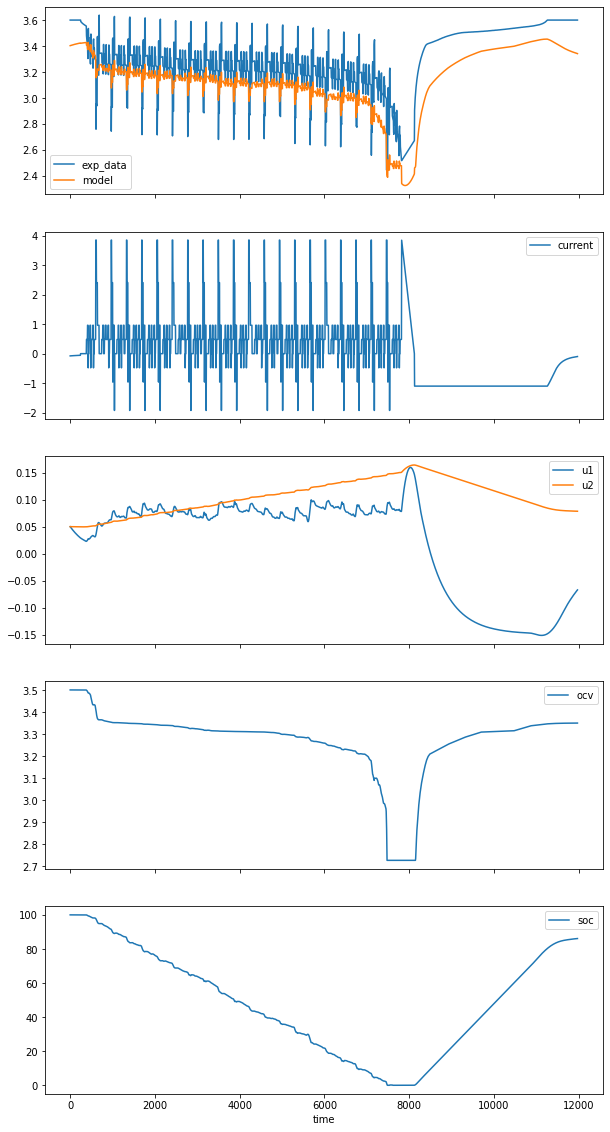

In [39]:


s3 = Simulator(name="s3")
s3.attach(d1).attach(m_exr)
d3 = s3.run(("cell_model_exr", "d1"), x0_sim)

fig,  ax = plt.subplots(5,1,sharex=True,figsize=(10,20))

# ax[0].set_ylim(bottom=2.5,top=3.8)
# ax[0].set_ylim(bottom=-.75,top=.1)
d1.df.plot(ax=ax[0],x='time',y='vt',label='exp_data')
d3.df.plot(ax=ax[0],x='time',y='vt',label='model' )
d1.df.plot(ax=ax[1],x='time',y='current',label='current')
d3.df.plot(ax=ax[2],x='time',y='u1',label='u1')
d3.df.plot(ax=ax[2],x='time',y='u2',label='u2')
d3.df.plot(ax=ax[3],x='time',y='ocv',label='ocv')
d3.df.plot(ax=ax[4],x='time',y='soc',label='soc')
plt.show()